# Hospital LOS (Length-of-Stay)
First of all what is LOS? **Hospital length-of-stay (LOS)** is defined as the time between hospital admission and discharge measured in days.

## 1. Problem Statement

**The goal is to create a model that predicts the length-of-stay for each patient at time of admission.**

In order to predict hospital LOS, the MIMIC data needed to be separated into terms of:
- dependent target variable (length-of-stay in this case) 
- and independent variables (features) to be used as inputs to the model. 

## 2. Type of model used for prediction
Since LOS is not a categorical but continuous variable (measured in days), a **regression model** will be used for prediction. 

## 3. Metrics used for validation
The expected outcome is that the model we use will be better at predicting hospital LOS than the industry standards of **median and average LOS**. The median LOS is simply the median LOS of past admissions to a hospital. Similarly, a second commonly used metric in healthcare is the average, or mean LOS. 

So, to measure performance of our model, we'll compare the prediction model against the median and average LOS using the root-mean-square error (RMSE). The RMSE is a commonly used measure of the differences between values predicted by a model and the values observed, where a *lower score implies better accuracy*. For example, a perfect prediction model would have an RMSE of 0. 

The RMSE equation for this work is given as follows, where (n) is the number of hospital admission records, (y-hat) the prediction LOS, and (y) is the actual LOS.

<img src="images/RMSE.png" alt="RMSE">

We could say we have a successful model if its prediction results in a lower RMSE than the average or median models.

There is a multitude of regression models available for predicting LOS. To determine the best regression model between the subset of models that will be evaluated, the **R2 (R-squared)** score will be used.

R Square measures how much variability in dependent variable can be explained by the model. In other words, it is the proportion of the variance in the dependent variable that is predictable from the independent variables. R2 is defined as the following equation where (y_i) is an observed data point, (ŷ) is the mean of the observed data, and (f_i) the predicted model value.

<img src="images/R2.png" alt="R2">

Best possible R2 score is 1.0 and a negative value means it is worse than a constant model, average or median in this case.

## 4. Data extraction, exploration and feature engineering

- The start point was to observe and analyze the tables in the dataset to understand how the data is distributed (Pandas libraries for Python is used to handle the tables as dataframes).
- The common functions of Pandas DataFrame to use for an overview of the table are the following:
  ``` python
  dataframe.info()
  dataframe.head()
  dataframe.describe()
  ```
- After reviewing the contents of the various tables in the MIMIC database, only some tables were selected and loaded into DataFrames using Pandas because it was assumed that it wasn't necessary or useful for prediction to include all tables. So the table selected are the following:    
    - **PATIENTS.csv** that defines a single patient, 
    - **ADMISSIONS.csv** that defines a patient’s hospital admission, 
    - **DIAGNOSES_ICD.csv** that contains ICD diagnoses for patients, most notably ICD-9 diagnoses (after this matter will be better explained),
    - **ICUSTAYS.csv** that defines a single ICU stay.

### ADMISSIONS table exploration and feature engineering

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV

In [146]:
mimic3_path = '../../mimic-iii-clinical-database-1.4/'

def dataframe_from_csv(path, header=0, index_col=0):
    return pd.read_csv(path, header=header, index_col=index_col)

# read admissions table
def read_admissions_table(mimic3_path):
    admits = dataframe_from_csv(mimic3_path + 'ADMISSIONS.csv')
    # Pre-emptively don't include some columns that I don't need
    admits = admits[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 'INSURANCE', 'ETHNICITY', 'DIAGNOSIS']]
    admits.ADMITTIME = pd.to_datetime(admits.ADMITTIME)
    admits.DISCHTIME = pd.to_datetime(admits.DISCHTIME)
    admits.DEATHTIME = pd.to_datetime(admits.DEATHTIME)
    return admits

admits = read_admissions_table(mimic3_path)
admits.head()

SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME DEATHTIME  \
ROW_ID                                                                          
21              22   165315 2196-04-09 12:26:00 2196-04-10 15:54:00       NaT   
22              23   152223 2153-09-03 07:15:00 2153-09-08 19:10:00       NaT   
23              23   124321 2157-10-18 19:34:00 2157-10-25 14:00:00       NaT   
24              24   161859 2139-06-06 16:14:00 2139-06-09 12:48:00       NaT   
25              25   129635 2160-11-02 02:06:00 2160-11-05 14:55:00       NaT   

       ADMISSION_TYPE INSURANCE ETHNICITY  \
ROW_ID                                      
21          EMERGENCY   Private     WHITE   
22           ELECTIVE  Medicare     WHITE   
23          EMERGENCY  Medicare     WHITE   
24          EMERGENCY   Private     WHITE   
25          EMERGENCY   Private     WHITE   

                                                DIAGNOSIS  
ROW_ID                                                     
21                                BENZODIAZEPINE OVERDOSE  
22      CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...  
23                                             BRAIN MASS  
24                         INTERIOR MYOCARDIAL INFARCTION  
25                                ACUTE CORONARY SYNDROME

#### Length of stays computation
The LOS is not explicitly expressed as attribute in the admission table, so we have to calculate it. As we said, LOS is defined as the time between admission and discharge from the hospital.

In [147]:
# Create LOS attribute converting timedelta type into float 'days', 86400 seconds in a day
admits['LOS'] = (admits['DISCHTIME'] - admits['ADMITTIME']).dt.total_seconds()/86400

# Verify LOS computation
admits[['ADMITTIME', 'DISCHTIME', 'LOS']].head()

ADMITTIME           DISCHTIME       LOS
ROW_ID                                                  
21     2196-04-09 12:26:00 2196-04-10 15:54:00  1.144444
22     2153-09-03 07:15:00 2153-09-08 19:10:00  5.496528
23     2157-10-18 19:34:00 2157-10-25 14:00:00  6.768056
24     2139-06-06 16:14:00 2139-06-09 12:48:00  2.856944
25     2160-11-02 02:06:00 2160-11-05 14:55:00  3.534028

In [148]:
# We could already have a quick insight on how LOS values are distributed
admits['LOS'].describe() 

count    58976.000000
mean        10.133916
std         12.456682
min         -0.945139
25%          3.743750
50%          6.467014
75%         11.795139
max        294.660417
Name: LOS, dtype: float64

We noticed that the mean LOS is 10 days, nut we noticed also that the min LOS calculated is a negative value, how is it possible that a LOS is negative? Let's see records associated with negative values of LOS:

In [149]:
admits[admits['LOS'] < 0]

SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
ROW_ID                                                                
534            417   102633 2177-03-23 16:17:00 2177-03-23 07:20:00   
237            181   102631 2153-10-12 09:49:00 2153-10-12 06:29:00   
644            516   187482 2197-07-31 20:18:00 2197-07-31 01:10:00   
1640          1334   138015 2137-09-02 14:43:00 2137-09-02 12:00:00   
1699          1381   181430 2189-01-02 14:25:00 2189-01-02 12:00:00   
...            ...      ...                 ...                 ...   
57980        96810   165589 2103-09-25 20:38:00 2103-09-25 12:00:00   
58635        98943   193747 2164-11-14 20:03:00 2164-11-14 12:00:00   
58720        99207   191004 2143-07-06 19:59:00 2143-07-06 12:00:00   
55950        90642   101946 2122-04-24 14:36:00 2122-04-24 12:00:00   
57477        95367   139266 2135-04-03 14:16:00 2135-04-03 12:00:00   

                 DEATHTIME ADMISSION_TYPE INSURANCE              ETHNICITY  \
ROW_ID                                                                       
534    2177-03-23 07:20:00         URGENT   Private                  WHITE   
237    2153-10-12 06:29:00      EMERGENCY   Private                  WHITE   
644    2197-07-31 01:10:00      EMERGENCY  Medicare  UNKNOWN/NOT SPECIFIED   
1640   2137-09-02 12:00:00        NEWBORN   Private                  WHITE   
1699   2189-01-02 12:00:00      EMERGENCY  Medicare                  WHITE   
...                    ...            ...       ...                    ...   
57980  2103-09-25 12:00:00      EMERGENCY  Medicaid                  WHITE   
58635  2164-11-14 12:00:00      EMERGENCY  Medicare                  WHITE   
58720  2143-07-06 12:00:00      EMERGENCY  Medicaid                  WHITE   
55950  2122-04-24 12:00:00      EMERGENCY   Private       UNABLE TO OBTAIN   
57477  2135-04-03 12:00:00      EMERGENCY  Medicare                  WHITE   

                                              DIAGNOSIS       LOS  
ROW_ID                                                             
534                                 ORGAN DONOR ACCOUNT -0.372917  
237                                DISSECTING ANEURYSIM -0.138889  
644                                RESPIRATORY DISTRESS -0.797222  
1640                                            NEWBORN -0.113194  
1699                                   STROKE;TELEMETRY -0.100694  
...                                                 ...       ...  
57980                                    CARDIAC ARREST -0.359722  
58635                           INTRACRANIAL HEMORRHAGE -0.335417  
58720                      GSW L. CHEST  WALL & ABDOMEN -0.332639  
55950   ST-SEGMENT ELEVATION MYOCARDIAL INFARCTION\CATH -0.108333  
57477                                        CHEST PAIN -0.094444  

[98 rows x 10 columns]

In [150]:
# We noticedd that rows with negative LOS, usually are related to a time of death before admission
# so in this case there is no use to predict LOS, so we drop these rows
admits = admits[admits['LOS'] > 0]
admits.describe()

SUBJECT_ID        HADM_ID           LOS
count  58878.000000   58878.000000  58878.000000
mean   33761.791382  149966.149886     10.151266
std    28092.613275   28882.995648     12.459774
min        2.000000  100001.000000      0.001389
25%    11999.250000  124942.750000      3.755556
50%    24141.000000  149987.000000      6.489583
75%    53862.750000  174958.000000     11.805556
max    99999.000000  199999.000000    294.660417

Now we see how the min value for LOS is not negative anymore. To have a more informative view on the distribution of LOS values we plot those values:

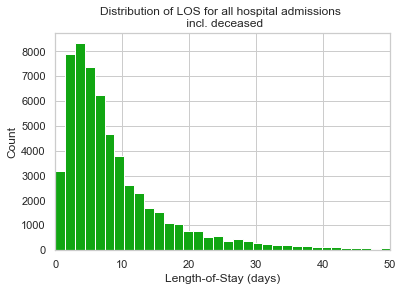

In [151]:
# Plot LOS Distribution
plt.hist(admits['LOS'], bins=200, color = '#11a612')
plt.xlim(0, 50)
plt.title('Distribution of LOS for all hospital admissions \n incl. deceased')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

In [152]:
# We also drop some other attributes from ADMISSIONS table that are not useful anymore for our prediction
admits.drop(columns='DISCHTIME', inplace=True)
admits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58878 entries, 21 to 58598
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   SUBJECT_ID      58878 non-null  int64         
 1   HADM_ID         58878 non-null  int64         
 2   ADMITTIME       58878 non-null  datetime64[ns]
 3   DEATHTIME       5774 non-null   datetime64[ns]
 4   ADMISSION_TYPE  58878 non-null  object        
 5   INSURANCE       58878 non-null  object        
 6   ETHNICITY       58878 non-null  object        
 7   DIAGNOSIS       58853 non-null  object        
 8   LOS             58878 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 4.5+ MB


Another thing to consider is admissions of patients who died at the hospital. This kind of admissions resulting in death will be excluded as they would bias the LOS since LOS would be shorter for this group.

In [153]:
# When DEATHTIME in ADMISSIONS is not null then the patient associated died at the hospital, so we mark these this distinction with a boolean variable
admits['DIED_AT_HOSPITAL'] = admits['DEATHTIME'].notnull().map({True:1, False:0})
print("{} of {} patients died at the hospital".format(admits['DIED_AT_HOSPITAL'].sum(), admits['SUBJECT_ID'].nunique()))

5774 of 46445 patients died at the hospital


We also said that we'll use the LOS mean and median for comparison and for understand the accuracy of our model. So let's compute these LOS metrics that we'll use later for model evalutaion.

In [154]:
# Hospital LOS metrics for later comparison
actual_mean_los = admits['LOS'].loc[admits['DIED_AT_HOSPITAL'] == 0].mean() 
actual_median_los = admits['LOS'].loc[admits['DIED_AT_HOSPITAL'] == 0].median() 

print(actual_mean_los)
print(actual_median_los)

10.138173704219758
6.565972222222222


#### Reduction number of categories of ETHNICITY, ADMISSION_TYPE, INSURANCE

In [155]:
# ETHNICITY
admits['ETHNICITY'].value_counts()

WHITE                                                       40939
BLACK/AFRICAN AMERICAN                                       5434
UNKNOWN/NOT SPECIFIED                                        4502
HISPANIC OR LATINO                                           1693
ASIAN                                                        1508
OTHER                                                        1507
UNABLE TO OBTAIN                                              809
PATIENT DECLINED TO ANSWER                                    559
ASIAN - CHINESE                                               277
HISPANIC/LATINO - PUERTO RICAN                                232
BLACK/CAPE VERDEAN                                            200
WHITE - RUSSIAN                                               164
MULTI RACE ETHNICITY                                          130
BLACK/HAITIAN                                                 101
ASIAN - ASIAN INDIAN                                           85
WHITE - OT

We notice that there are a lot of ETHNICITY categories, but most of them are subcategories so we could reduce this number just by considering the main category.

In [156]:
# Compress the number of ethnicity categories
admits['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
admits['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
admits['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
admits['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
admits['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
#take into consideration just the top-5 categories with biggest value_count, the others will fall into OTHER category
admits['ETHNICITY'].loc[~admits['ETHNICITY'].isin(admits['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'  
admits['ETHNICITY'].value_counts()

C:\Users\nicod\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


WHITE                     41268
OTHER/UNKNOWN              7700
BLACK/AFRICAN AMERICAN     5779
HISPANIC/LATINO            2125
ASIAN                      2006
Name: ETHNICITY, dtype: int64

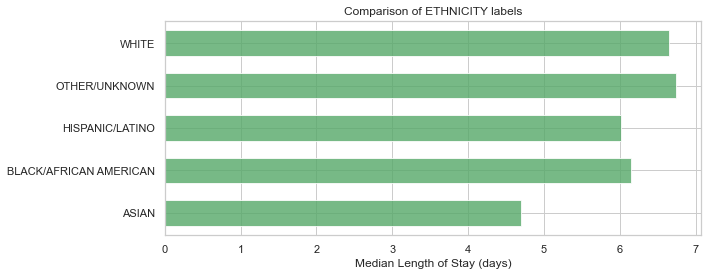

In [157]:
# Re-usable plotting function
def plot_los_groupby(variable, size=(7,4)):
    ''' 
    Plot Median LOS by dataframe categorical series name 
    '''
    results = admits[[variable, 'LOS']].groupby(variable).median().reset_index()
    values = list(results['LOS'].values)
    labels = list(results[variable].values)

    fig, ax = plt.subplots(figsize=size)
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, color = '#55a868', alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Median Length of Stay (days)')
    ax.tick_params(left=False, top=False, right=False) 
    ax.set_title('Comparison of {} labels'.format(variable))
    
    plt.tight_layout()
    plt.show();

# Look at median LOS for groups ETHNICITY
plot_los_groupby('ETHNICITY', size=(10,4))

It's interesting to notice that ASIAN patients have the lowest median LOS, even if they are smaller in number in comparison to other ETHNICITY categories.

Now let's do the same analysis done for ETHNICITY also for ADMISSION_TYPE and INSURANCE, if necessary, to reduce the number of possible categories.

In [158]:
# ADMISSION_TYPE
admits['ADMISSION_TYPE'].value_counts()

EMERGENCY    41989
NEWBORN       7854
ELECTIVE      7702
URGENT        1333
Name: ADMISSION_TYPE, dtype: int64

The number og categories in ADMISSION_TYPE is not that high, but the category URGENT contains a smaller subset of entries in comparison to others. In addition it is a lot similar semantically to EMERGENCY, so could combine these two categories and consider URGENT as EMERGENCY.

In [159]:
admits['ADMISSION_TYPE'].replace(to_replace='URGENT', value='EMERGENCY', inplace=True)
admits['ADMISSION_TYPE'].value_counts()

EMERGENCY    43322
NEWBORN       7854
ELECTIVE      7702
Name: ADMISSION_TYPE, dtype: int64

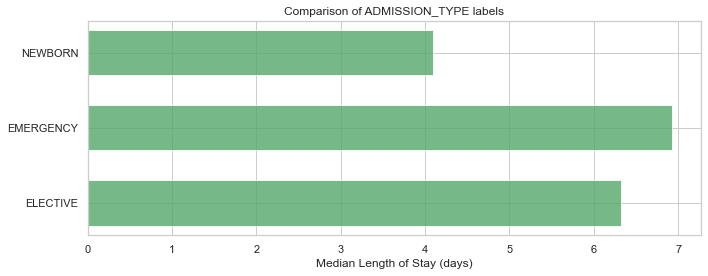

In [160]:
# Look at median LOS for groups ADMISSION_TYPE
plot_los_groupby('ADMISSION_TYPE', size=(10,4))

In [161]:
As we could expected newborns have the lowest median LOS followed by elective admissions. This is expected since these are often somewhat planned for and with the risks being understood in comparison to EMERGENCY ADMISSION_TYPE.

Finally, let's do the same fot INSURANCE feature.

SyntaxError: invalid syntax (<ipython-input-161-bf26a8e84819>, line 1)

In [ ]:
admits['INSURANCE'].value_counts()

Analyzing this attribute we see that the categories are pretty distinct, but we notice that if a patient is 'Self-Pay', typically it could mean that they can't or didn't pay, as matter of fact, Self-pay patients have the lowest LOS because they can't pay to stay more at the hospital.

### PATIENTS table exploration and feature engineering


In [18]:
# read patients table
def read_patients_table(mimic3_path):
    pats = dataframe_from_csv(mimic3_path + 'PATIENTS.csv')
    # Pre-emptively don't include some columns that I don't need
    pats = pats[['SUBJECT_ID', 'GENDER', 'DOB', 'DOD']]
    pats.DOB = pd.to_datetime(pats.DOB)
    pats.DOD = pd.to_datetime(pats.DOD)
    return pats

patients = read_patients_table(mimic3_path)
patients.head()

SUBJECT_ID GENDER        DOB        DOD
ROW_ID                                         
234            249      F 2075-03-13        NaT
235            250      F 2164-12-27 2188-11-22
236            251      M 2090-03-15        NaT
237            252      M 2078-03-06        NaT
238            253      F 2089-11-26        NaT

In PATIENTS table we have DOB (Date of Birth) but not the age of the patient, so to have a look on the age distribution between patients we have to compute this AGE attribute. We can compute it with the difference between a patient date of birth (DOB) and th date of their first admission, so we ignore subsequent admissions in this calculation.

To do this, let's first merge the PATIENTS table with ADMISSIONS table explored previosly.

In [21]:
# drop DOD (Date of Death because it is already present in ADMISSIONS table)
patients = patients[['SUBJECT_ID', 'GENDER', 'DOB']]
# merge the PATIENTS table with ADMISSIONS table
admits_patients = pd.merge(admits, patients, how='inner', on='SUBJECT_ID')
admits_patients.head()

SUBJECT_ID  HADM_ID           ADMITTIME DEATHTIME ADMISSION_TYPE INSURANCE  \
0          22   165315 2196-04-09 12:26:00       NaT      EMERGENCY   Private   
1          23   152223 2153-09-03 07:15:00       NaT       ELECTIVE  Medicare   
2          23   124321 2157-10-18 19:34:00       NaT      EMERGENCY  Medicare   
3          24   161859 2139-06-06 16:14:00       NaT      EMERGENCY   Private   
4          25   129635 2160-11-02 02:06:00       NaT      EMERGENCY   Private   

  ETHNICITY                                          DIAGNOSIS       LOS  \
0     WHITE                            BENZODIAZEPINE OVERDOSE  1.144444   
1     WHITE  CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...  5.496528   
2     WHITE                                         BRAIN MASS  6.768056   
3     WHITE                     INTERIOR MYOCARDIAL INFARCTION  2.856944   
4     WHITE                            ACUTE CORONARY SYNDROME  3.534028   

   DIED_AT_HOSPITAL GENDER        DOB  
0                 0      F 2131-05-07  
1                 0      M 2082-07-17  
2                 0      M 2082-07-17  
3                 0      M 2100-05-31  
4                 0      M 2101-11-21

#### Age calculation

In [22]:
# Find the first admission date for each patient
admits_patients_age_min = admits_patients[['SUBJECT_ID', 'ADMITTIME']].groupby('SUBJECT_ID').min().reset_index()
admits_patients_age_min.columns = ['SUBJECT_ID', 'ADMIT_MIN']
admits_patients_age_min.head()

SUBJECT_ID           ADMIT_MIN
0           2 2138-07-17 19:04:00
1           3 2101-10-20 19:08:00
2           4 2191-03-16 00:28:00
3           5 2103-02-02 04:31:00
4           6 2175-05-30 07:15:00

In [23]:
# merge with the created table containing the first admission for each patient
admits_patients = admits_patients.merge(admits_patients_age_min, how='outer', on='SUBJECT_ID')
admits_patients.head()

SUBJECT_ID  HADM_ID           ADMITTIME DEATHTIME ADMISSION_TYPE INSURANCE  \
0          22   165315 2196-04-09 12:26:00       NaT      EMERGENCY   Private   
1          23   152223 2153-09-03 07:15:00       NaT       ELECTIVE  Medicare   
2          23   124321 2157-10-18 19:34:00       NaT      EMERGENCY  Medicare   
3          24   161859 2139-06-06 16:14:00       NaT      EMERGENCY   Private   
4          25   129635 2160-11-02 02:06:00       NaT      EMERGENCY   Private   

  ETHNICITY                                          DIAGNOSIS       LOS  \
0     WHITE                            BENZODIAZEPINE OVERDOSE  1.144444   
1     WHITE  CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...  5.496528   
2     WHITE                                         BRAIN MASS  6.768056   
3     WHITE                     INTERIOR MYOCARDIAL INFARCTION  2.856944   
4     WHITE                            ACUTE CORONARY SYNDROME  3.534028   

   DIED_AT_HOSPITAL GENDER        DOB           ADMIT_MIN  
0                 0      F 2131-05-07 2196-04-09 12:26:00  
1                 0      M 2082-07-17 2153-09-03 07:15:00  
2                 0      M 2082-07-17 2153-09-03 07:15:00  
3                 0      M 2100-05-31 2139-06-06 16:14:00  
4                 0      M 2101-11-21 2160-11-02 02:06:00

In [49]:
# Now we can compute the age by finding the difference between first admission date and date of birth
admits_patients['AGE'] = (admits_patients['ADMIT_MIN'].subtract(admits_patients['DOB'])).dt.days // 365
# DOB has been shifted for patients older than 89 to obscure their age and comply with HIPAA, the median age for the patients whose date of birth was shifted is 91.4
admits_patients['AGE'] = np.where(admits_patients['AGE'] < 0, 91.4, admits_patients['AGE'])
admits_patients['AGE'].isnull().sum()

0

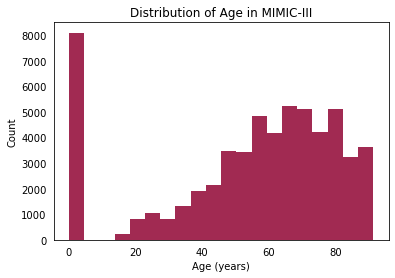

In [50]:
#let's see the distribution of age
plt.hist(admits_patients['AGE'], bins=20, color='#a12a52')
plt.ylabel('Count')
plt.xlabel('Age (years)')
plt.title('Distribution of Age in MIMIC-III')
plt.tick_params(left=False, bottom=False, top=False, right=False) 
plt.show()

As we can see from age distribution, patients in their childhood are not present, this reflects the fact that MIMIC-III does not contain data from pediatric patients.

Now let's see how the LOS, our current goal, is correlated to ther age of the patients.

(1.0, 50.0)

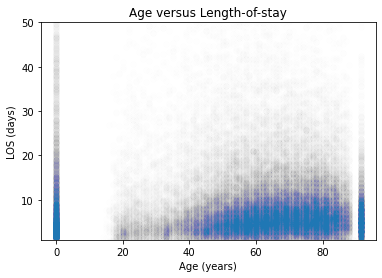

In [51]:
plt.scatter(admits_patients['AGE'], admits_patients['LOS'], alpha=0.005)
plt.ylabel('LOS (days)')
plt.xlabel('Age (years)')
plt.title('Age versus Length-of-stay')
plt.ylim(1, 50)

The plot highlights the MIMIC groups of newborns and >89 year olds, and there is an increasing amount of admissions going from 20 toward 80 years old. Because of the discrete-like distribution of data on the extremes of age, it could be useful to convert all ages into the categories of **newborn, young adult, middle adult, and senior** for use in the prediction model.

In [53]:
age_ranges = [(0, 13), (13, 36), (36, 56), (56, 100)]
for num, cat_range in enumerate(age_ranges):
    admits_patients['AGE'] = np.where(admits_patients['AGE'].between(cat_range[0],cat_range[1]), num, admits_patients['AGE'])

age_dict = {0: 'NEWBORN', 1: 'YOUNG_ADULT', 2: 'MIDDLE_ADULT', 3: 'SENIOR'}
admits_patients['AGE'] = admits_patients['AGE'].replace(age_dict)
admits_patients.AGE.value_counts()

SENIOR          33785
MIDDLE_ADULT    12732
NEWBORN          8101
YOUNG_ADULT      4260
Name: AGE, dtype: int64

In [ ]:
Finally, let's see the distribution of gender in patients in correlation to LOS, before to explore the next table.

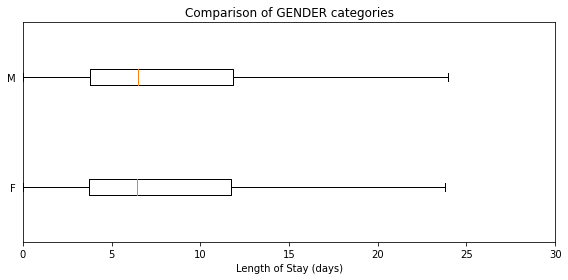

In [56]:
# Re-usable boxplot function
def boxplot_los_groupby(variable, los_range=(-1, 30), size=(8,4)):
    ''' 
    Boxplot of LOS by df categorical series name 
    '''
    results = admits_patients[[variable, 'LOS']].groupby(variable).median().reset_index()

    categories = results[variable].values.tolist()

    hist_data = []
    for cat in categories:
        hist_data.append(admits_patients['LOS'].loc[admits_patients[variable]==cat].values)

    fig, ax = plt.subplots(figsize=size)
    ax.boxplot(hist_data, 0, '', vert=False)
    ax.set_xlim(los_range)
    ax.set_yticklabels(categories)
    ax.set_xlabel('Length of Stay (days)')
    ax.tick_params(left=False, right=False) 
    ax.set_title('Comparison of {} categories'.format(variable))
    plt.tight_layout()
    plt.show();

boxplot_los_groupby('GENDER', los_range=(0, 30))
admits_patients['GENDER'].replace({'M': 0, 'F':1}, inplace=True)

### DIAGNOSES_ICD table exploration and feature engineering


In [73]:
# read diagnoses_icd table
def read_diagnoses_icd_table(mimic3_path):
    diag_icds = dataframe_from_csv(mimic3_path + 'DIAGNOSES_ICD.csv')
    return diag_icds

diag_icds = read_diagnoses_icd_table(mimic3_path)
diag_icds.head()

SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE
ROW_ID                                        
1297           109   172335      1.0     40301
1298           109   172335      2.0       486
1299           109   172335      3.0     58281
1300           109   172335      4.0      5855
1301           109   172335      5.0      4254

International Classification of Diseases, Clinical Modification (ICD-9-CM) is an adaption created by the U.S. National Center for Health Statistics (NCHS) and used in assigning diagnostic and procedure codes associated with inpatient, outpatient, and physician office utilization in the United States (from WIKIPEDIA https://en.wikipedia.org/wiki/International_Classification_of_Diseases#ICD-9 ).

In [66]:
print('There are {} unique ICD9 codes in this dataset.'.format(diag_icds['ICD9_CODE'].value_counts().count()))

There are 6984 unique ICD9 codes in this dataset.


Because it's not feasible to have 6984 unique values to use as features for predicting LOS, it is necessary to reduce the diagnosis into more general categories. After researching the ICD9 approach, (from WKIPEDIA source https://en.wikipedia.org/wiki/List_of_ICD-9_codes) it's been noticed that they are arranged into super categories as the following:

<img src="images/listICD9codes.png" alt="listICD9codes">

As we see our attention could be just on the numeric first 3 values. So our task now is to recode each ICD-9 code to its supercategory.

In [74]:
# Filter out E and V codes since processing will be done on the numeric first 3 values
diag_icds['RECODE'] = diag_icds['ICD9_CODE']
diag_icds['RECODE'] = diag_icds['RECODE'][~diag_icds['RECODE'].str.contains("[a-zA-Z]").fillna(False)]
diag_icds['RECODE'].fillna(value='999', inplace=True)

# Take in consideration just the first 3 numeri integers of the ICD9 code
diag_icds['RECODE'] = diag_icds['RECODE'].str.slice(start=0, stop=3, step=1)
diag_icds['RECODE'] = diag_icds['RECODE'].astype(int)
diag_icds.head()

SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE  RECODE
ROW_ID                                                
1297           109   172335      1.0     40301     403
1298           109   172335      2.0       486     486
1299           109   172335      3.0     58281     582
1300           109   172335      4.0      5855     585
1301           109   172335      5.0      4254     425

In [75]:
# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    diag_icds['RECODE'] = np.where(diag_icds['RECODE'].between(cat_range[0],cat_range[1]), num, diag_icds['RECODE'])
    
# Convert integer to category name using diag_dict
diag_icds['SUPER_CATEGORY'] = diag_icds['RECODE'].replace(diag_dict)
diag_icds.head()

SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE  RECODE SUPER_CATEGORY
ROW_ID                                                               
1297           109   172335      1.0     40301       6    circulatory
1298           109   172335      2.0       486       7    respiratory
1299           109   172335      3.0     58281       9  genitourinary
1300           109   172335      4.0      5855       9  genitourinary
1301           109   172335      5.0      4254       6    circulatory

For each admission, usually there is more than one diagnosis. Often, there are more than 1 diagnoses for 1 category. 

We could create a matrix that highlights all the diagnoses for each admission. This should not be done on the SUBJECT_ID since each patient could have different diagnoses for each admission.

In [76]:
# Create list of diagnoses for each admission
hadm_list = diag_icds.groupby('HADM_ID')['SUPER_CATEGORY'].apply(list).reset_index()
hadm_list.head()

HADM_ID                                     SUPER_CATEGORY
0   100001  [endocrine, nervous, genitourinary, digestive,...
1   100003  [digestive, blood, infectious, digestive, circ...
2   100006  [respiratory, respiratory, respiratory, neopla...
3   100007  [digestive, digestive, injury, respiratory, ci...
4   100009  [circulatory, injury, circulatory, endocrine, ...

In [77]:
# Convert diagnoses list into hospital admission-item matrix
hadm_item = pd.get_dummies(hadm_list['SUPER_CATEGORY'].apply(pd.Series).stack()).sum(level=0)
hadm_item.head()

blood  circulatory  congenital  digestive  endocrine  genitourinary  \
0      0            2           0          2          5              2   
1      1            2           0          4          0              0   
2      0            0           0          0          1              0   
3      0            1           0          2          0              0   
4      1            7           0          0          3              0   

   infectious  injury  mental  misc  muscular  neoplasms  nervous  pregnancy  \
0           0       2       0     0         0          0        2          0   
1           1       0       0     1         0          0        0          0   
2           0       2       1     1         0          1        0          0   
3           0       1       0     0         0          0        0          0   
4           0       7       0     0         0          0        0          0   

   prenatal  respiratory  skin  
0         0            0     1  
1         0            0     0  
2         0            3     0  
3         0            1     0  
4         0            0     0

In [78]:
# Join back with HADM_ID
hadm_item = hadm_item.join(hadm_list['HADM_ID'], how="outer")
# Merge with main admissions dataframe
admits_patients_diag = pd.merge(admits_patients, hadm_item, how='inner', on='HADM_ID')
admits_patients_diag.head()

SUBJECT_ID  HADM_ID           ADMITTIME DEATHTIME ADMISSION_TYPE INSURANCE  \
0          22   165315 2196-04-09 12:26:00       NaT      EMERGENCY   Private   
1          23   152223 2153-09-03 07:15:00       NaT       ELECTIVE  Medicare   
2          23   124321 2157-10-18 19:34:00       NaT      EMERGENCY  Medicare   
3          24   161859 2139-06-06 16:14:00       NaT      EMERGENCY   Private   
4          25   129635 2160-11-02 02:06:00       NaT      EMERGENCY   Private   

  ETHNICITY                                          DIAGNOSIS       LOS  \
0     WHITE                            BENZODIAZEPINE OVERDOSE  1.144444   
1     WHITE  CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...  5.496528   
2     WHITE                                         BRAIN MASS  6.768056   
3     WHITE                     INTERIOR MYOCARDIAL INFARCTION  2.856944   
4     WHITE                            ACUTE CORONARY SYNDROME  3.534028   

   DIED_AT_HOSPITAL  ...  injury mental misc muscular  neoplasms  nervous  \
0                 0  ...       4      1    0        0          0        1   
1                 0  ...       1      0    0        0          0        1   
2                 0  ...       3      0    0        0          1        1   
3                 0  ...       0      0    0        0          0        0   
4                 0  ...       0      0    0        0          0        0   

   pregnancy  prenatal  respiratory  skin  
0          0         0            0     0  
1          0         0            0     0  
2          0         1            0     0  
3          0         0            0     0  
4          0         0            0     0  

[5 rows x 31 columns]

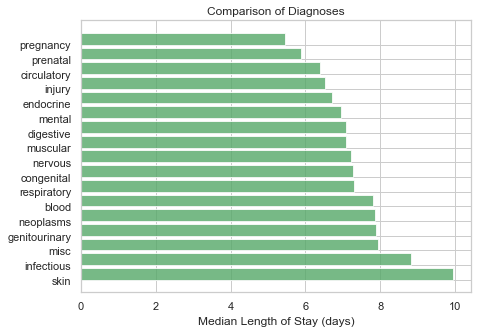

In [81]:
# Look at the median LOS by diagnosis category
diag_cat_list = ['skin', 'infectious',  'misc', 'genitourinary', 'neoplasms', 'blood', 'respiratory', 
                  'congenital','nervous', 'muscular', 'digestive', 'mental', 'endocrine', 'injury',
                 'circulatory', 'prenatal',  'pregnancy']

results = []
for variable in diag_cat_list:
    results.append(admits_patients_diag[[variable, 'LOS']].groupby(variable).median().reset_index().values[1][1])

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(7,5))
ind = range(len(results))
ax.barh(ind, results, align='edge', color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(diag_cat_list)
ax.set_xlabel('Median Length of Stay (days)')
ax.tick_params(left=False, right=False, top=False) 
ax.set_title('Comparison of Diagnoses'.format(variable))
plt.show();

Looking at the median LOS for each ICD-9 supercategory shows an impressive spread between pregnancy and skin diagnosis code groups.

### ICUSTAYS table exploration and feature engineering

In [83]:
# read icustays table
def read_icustays_table(mimic3_path):
    icustays = dataframe_from_csv(mimic3_path + 'ICUSTAYS.csv')
    return icustays

icustays = read_icustays_table(mimic3_path)
icustays.head()

SUBJECT_ID  HADM_ID  ICUSTAY_ID DBSOURCE FIRST_CAREUNIT LAST_CAREUNIT  \
ROW_ID                                                                          
365            268   110404      280836  carevue           MICU          MICU   
366            269   106296      206613  carevue           MICU          MICU   
367            270   188028      220345  carevue            CCU           CCU   
368            271   173727      249196  carevue           MICU          SICU   
369            272   164716      210407  carevue            CCU           CCU   

        FIRST_WARDID  LAST_WARDID               INTIME              OUTTIME  \
ROW_ID                                                                        
365               52           52  2198-02-14 23:27:38  2198-02-18 05:26:11   
366               52           52  2170-11-05 11:05:29  2170-11-08 17:46:57   
367               57           57  2128-06-24 15:05:20  2128-06-27 12:32:29   
368               52           23  2120-08-07 23:12:42  2120-08-10 00:39:04   
369               57           57  2186-12-25 21:08:04  2186-12-27 12:01:13   

           LOS  
ROW_ID          
365     3.2490  
366     3.2788  
367     2.8939  
368     2.0600  
369     1.6202

In [84]:
icustays.groupby('FIRST_CAREUNIT').median()

SUBJECT_ID   HADM_ID  ICUSTAY_ID  FIRST_WARDID  LAST_WARDID  \
FIRST_CAREUNIT                                                                
CCU                22964.5  150074.5    249373.5           7.0          7.0   
CSRU               24488.0  150225.0    250492.0          14.0         14.0   
MICU               26489.5  150368.0    250524.0          50.0         50.0   
NICU               15456.5  149206.5    249308.0          56.0         56.0   
SICU               30084.0  149744.0    248649.0          33.0         33.0   
TSICU              28716.0  148915.0    250685.0          14.0         14.0   

                    LOS  
FIRST_CAREUNIT           
CCU             2.19775  
CSRU            2.15290  
MICU            2.09550  
NICU            0.80250  
SICU            2.25220  
TSICU           2.11150

From this statistic we can see how, as far as LOS is concerned, a substantial difference in the median is found only between NICU and the other categories. The other categories have a very similar median. We can therefore think of simply reducing on two groups: NICU and ICU (which includes all the others).

In [86]:
icustays['FIRST_CAREUNIT'].replace({'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU','SICU': 'ICU', 'TSICU': 'ICU'}, inplace=True)

icustays['CATEGORY'] = icustays['FIRST_CAREUNIT']
icu_list = icustays.groupby('HADM_ID')['CATEGORY'].apply(list).reset_index()
icu_list.head()

HADM_ID CATEGORY
0   100001    [ICU]
1   100003    [ICU]
2   100006    [ICU]
3   100007    [ICU]
4   100009    [ICU]

In [87]:
icustays['FIRST_CAREUNIT'].value_counts()

ICU     53432
NICU     8100
Name: FIRST_CAREUNIT, dtype: int64

In [88]:
# Create admission-ICU matrix
icu_item = pd.get_dummies(icu_list['CATEGORY'].apply(pd.Series).stack()).sum(level=0)
icu_item[icu_item >= 1] = 1
icu_item = icu_item.join(icu_list['HADM_ID'], how="outer")
icu_item.head()

ICU  NICU  HADM_ID
0    1     0   100001
1    1     0   100003
2    1     0   100006
3    1     0   100007
4    1     0   100009

In [90]:
# Merge ICU data with main dataFrame
final_df = admits_patients_diag.merge(icu_item, how='outer', on='HADM_ID')
final_df.head()

SUBJECT_ID  HADM_ID           ADMITTIME DEATHTIME ADMISSION_TYPE INSURANCE  \
0        22.0   165315 2196-04-09 12:26:00       NaT      EMERGENCY   Private   
1        23.0   152223 2153-09-03 07:15:00       NaT       ELECTIVE  Medicare   
2        23.0   124321 2157-10-18 19:34:00       NaT      EMERGENCY  Medicare   
3        24.0   161859 2139-06-06 16:14:00       NaT      EMERGENCY   Private   
4        25.0   129635 2160-11-02 02:06:00       NaT      EMERGENCY   Private   

  ETHNICITY                                          DIAGNOSIS       LOS  \
0     WHITE                            BENZODIAZEPINE OVERDOSE  1.144444   
1     WHITE  CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...  5.496528   
2     WHITE                                         BRAIN MASS  6.768056   
3     WHITE                     INTERIOR MYOCARDIAL INFARCTION  2.856944   
4     WHITE                            ACUTE CORONARY SYNDROME  3.534028   

   DIED_AT_HOSPITAL  ...  misc muscular neoplasms nervous  pregnancy  \
0               0.0  ...   0.0      0.0       0.0     1.0        0.0   
1               0.0  ...   0.0      0.0       0.0     1.0        0.0   
2               0.0  ...   0.0      0.0       1.0     1.0        0.0   
3               0.0  ...   0.0      0.0       0.0     0.0        0.0   
4               0.0  ...   0.0      0.0       0.0     0.0        0.0   

   prenatal  respiratory  skin  ICU  NICU  
0       0.0          0.0   0.0  1.0   0.0  
1       0.0          0.0   0.0  1.0   0.0  
2       1.0          0.0   0.0  1.0   0.0  
3       0.0          0.0   0.0  1.0   0.0  
4       0.0          0.0   0.0  1.0   0.0  

[5 rows x 33 columns]

In [92]:
# Replace NaNs with 0
final_df['ICU'].fillna(value=0, inplace=True)
final_df['NICU'].fillna(value=0, inplace=True)

In [93]:
# Verify NaN fix
print(final_df.ICU.value_counts(dropna=False))
print(final_df.NICU.value_counts(dropna=False))

1.0    49794
0.0     9168
Name: ICU, dtype: int64
0.0    50970
1.0     7992
Name: NICU, dtype: int64


## Data cleaning

In [123]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58962 entries, 0 to 58961
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   SUBJECT_ID        58878 non-null  float64       
 1   HADM_ID           58962 non-null  int64         
 2   ADMITTIME         58878 non-null  datetime64[ns]
 3   DEATHTIME         5774 non-null   datetime64[ns]
 4   ADMISSION_TYPE    58878 non-null  object        
 5   INSURANCE         58878 non-null  object        
 6   ETHNICITY         58878 non-null  object        
 7   DIAGNOSIS         58853 non-null  object        
 8   LOS               58878 non-null  float64       
 9   DIED_AT_HOSPITAL  58878 non-null  float64       
 10  GENDER            58878 non-null  float64       
 11  DOB               58878 non-null  datetime64[ns]
 12  ADMIT_MIN         58878 non-null  datetime64[ns]
 13  AGE               58878 non-null  object        
 14  blood             5887

In [ ]:
# Remove deceased persons as they will skew LOS result
final_df = final_df[final_df['DIED_AT_HOSPITAL'] == 0]

# Remove LOS with negative number, likely entry form error
final_df = final_df[admits['LOS'] > 0]

In [124]:
# Drop unused or no longer needed columns
final_df.drop(columns=['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ADMIT_MIN', 'DOB',
                'DIAGNOSIS', 'DIED_AT_HOSPITAL',  'DEATHTIME'], inplace=True)

final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58962 entries, 0 to 58961
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ADMISSION_TYPE  58878 non-null  object 
 1   INSURANCE       58878 non-null  object 
 2   ETHNICITY       58878 non-null  object 
 3   LOS             58878 non-null  float64
 4   GENDER          58878 non-null  float64
 5   AGE             58878 non-null  object 
 6   blood           58878 non-null  float64
 7   circulatory     58878 non-null  float64
 8   congenital      58878 non-null  float64
 9   digestive       58878 non-null  float64
 10  endocrine       58878 non-null  float64
 11  genitourinary   58878 non-null  float64
 12  infectious      58878 non-null  float64
 13  injury          58878 non-null  float64
 14  mental          58878 non-null  float64
 15  misc            58878 non-null  float64
 16  muscular        58878 non-null  float64
 17  neoplasms       58878 non-null 

In [125]:
final_df.head()

ADMISSION_TYPE INSURANCE ETHNICITY       LOS  GENDER           AGE  blood  \
0      EMERGENCY   Private     WHITE  1.144444     1.0        SENIOR    0.0   
1       ELECTIVE  Medicare     WHITE  5.496528     0.0        SENIOR    0.0   
2      EMERGENCY  Medicare     WHITE  6.768056     0.0        SENIOR    0.0   
3      EMERGENCY   Private     WHITE  2.856944     0.0  MIDDLE_ADULT    0.0   
4      EMERGENCY   Private     WHITE  3.534028     0.0        SENIOR    0.0   

   circulatory  congenital  digestive  ...  misc  muscular  neoplasms  \
0          1.0         0.0        0.0  ...   0.0       0.0        0.0   
1          4.0         0.0        0.0  ...   0.0       0.0        0.0   
2          2.0         0.0        0.0  ...   0.0       0.0        1.0   
3          2.0         0.0        1.0  ...   0.0       0.0        0.0   
4          3.0         0.0        0.0  ...   0.0       0.0        0.0   

   nervous  pregnancy  prenatal  respiratory  skin  ICU  NICU  
0      1.0        0.0       0.0          0.0   0.0  1.0   0.0  
1      1.0        0.0       0.0          0.0   0.0  1.0   0.0  
2      1.0        0.0       1.0          0.0   0.0  1.0   0.0  
3      0.0        0.0       0.0          0.0   0.0  1.0   0.0  
4      0.0        0.0       0.0          0.0   0.0  1.0   0.0  

[5 rows x 25 columns]

In [126]:
# Create dummy columns for categorical variables
prefix_cols = ['ADM', 'INS', 'ETH', 'AGE']
dummy_cols = ['ADMISSION_TYPE', 'INSURANCE','ETHNICITY', 'AGE']
final_df = pd.get_dummies(final_df, prefix=prefix_cols, columns=dummy_cols)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58962 entries, 0 to 58961
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LOS                         58878 non-null  float64
 1   GENDER                      58878 non-null  float64
 2   blood                       58878 non-null  float64
 3   circulatory                 58878 non-null  float64
 4   congenital                  58878 non-null  float64
 5   digestive                   58878 non-null  float64
 6   endocrine                   58878 non-null  float64
 7   genitourinary               58878 non-null  float64
 8   infectious                  58878 non-null  float64
 9   injury                      58878 non-null  float64
 10  mental                      58878 non-null  float64
 11  misc                        58878 non-null  float64
 12  muscular                    58878 non-null  float64
 13  neoplasms                   588

In [183]:
# Verify NaN values
for attr in final_df:
    final_df.dropna(subset = [attr], inplace=True)


In [186]:
# Check for any remaining NaNs
final_df.count()

LOS                           58878
GENDER                        58878
blood                         58878
circulatory                   58878
congenital                    58878
digestive                     58878
endocrine                     58878
genitourinary                 58878
infectious                    58878
injury                        58878
mental                        58878
misc                          58878
muscular                      58878
neoplasms                     58878
nervous                       58878
pregnancy                     58878
prenatal                      58878
respiratory                   58878
skin                          58878
ICU                           58878
NICU                          58878
ADM_ELECTIVE                  58878
ADM_EMERGENCY                 58878
ADM_NEWBORN                   58878
ADM_URGENT                    58878
INS_Government                58878
INS_Medicaid                  58878
INS_Medicare                